In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

2023-03-07 23:35:07.445132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 23:35:07.972113: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-07 23:35:07.972198: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/prp/anaconda3/lib/
2023-03-07 23:35:07.972205: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2023-03-07 23:35:16.029304: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-07 23:35:16.034751: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-07 23:35:16.034802: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_data(path, col=None, verbose=False):
    df = pd.read_csv(path)
    if col is not None:
        df = df[col]
    if verbose:
        print(df.head())
    return df

In [9]:
data_path = "/mnt/d/Learning/tensorflow_learning/datasets/POP.csv"
data = load_data(data_path)
data

,realtime_start,value,date,realtime_end
0,2019-12-06,76094000,1900-01-01,2019-12-06
1,2019-12-06,77584000,1901-01-01,2019-12-06
2,2019-12-06,79163000,1902-01-01,2019-12-06
3,2019-12-06,80632000,1903-01-01,2019-12-06
4,2019-12-06,82166000,1904-01-01,2019-12-06
...,...,...,...,...
95,2019-12-06,262803276,1995-01-01,2019-12-06
96,2019-12-06,265228572,1996-01-01,2019-12-06
97,2019-12-06,267783607,1997-01-01,2019-12-06
98,2019-12-06,270248003,1998-01-01,2019-12-06


In [4]:
def clean_data(series):
    """Fills missing values. 
    
        Interpolate missing values with a linear approximation.
    """
    series_filled = series.interpolate(method='linear')
        
    return series_filled
        
    
def min_max_scale(dataframe):
    """ Applies MinMax Scaling
    
        Wrapper for sklearn's MinMaxScaler class.
    """
    mm = MinMaxScaler()
    return mm.fit_transform(dataframe)

In [5]:
def make_time_features(series):
    
    #convert series to datetimes
    datetimes = pd.DatetimeIndex(series)
    
    days = datetimes.day.values
    months = datetimes.month.values
    years = datetimes.year.values
    
    day = pd.Series(days, name='day')
    month = pd.Series(months, name='months')
    year = pd.Series(years, name='year')
    
    return day, month, year

In [6]:
def split_data(series, train_fraq):
    """Splits input series into train, val and test.
    
        Default to 1 year of test data.
    """
    #make train and validation from the remaining
    train_val_data = series
    train_size = int(len(train_val_data) * train_fraq)
    
    train_data = train_val_data[:train_size]
    val_data = train_val_data[train_size:]
    test_data = val_data
    
    return train_data, val_data, test_data

In [7]:
def window_dataset(data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=False, expand_dims=False):
    """ Create a windowed tensorflow dataset
    
    """

    #create a window with n steps back plus the size of the prediction length
    window = n_steps + n_horizon
    
    #expand dimensions to 3D to fit with LSTM inputs
    #creat the inital tensor dataset
    if expand_dims:
        ds = tf.expand_dims(data, axis=-1)
        ds = tf.data.Dataset.from_tensor_slices(ds)
    else:
        ds = tf.data.Dataset.from_tensor_slices(data)
    
    #create the window function shifting the data by the prediction length
    ds = ds.window(window, shift=n_horizon, drop_remainder=True)
    
    #flatten the dataset and batch into the window size
    ds = ds.flat_map(lambda x : x.batch(window))
    ds = ds.shuffle(shuffle_buffer)    
    
    #create the supervised learning problem x and y and batch
    if multi_var:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:, :1]))
    else:
        ds = ds.map(lambda x : (x[:-n_horizon], x[-n_horizon:]))
    
    ds = ds.batch(batch_size).prefetch(1)
    
    return ds

In [14]:
def build_dataset(train_fraq=0.80, n_steps=24, n_horizon=1, batch_size=256, shuffle_buffer=500, expand_dims=False, multi_var=False):
    """If multi variate then first column is always the column from which the target is contstructed.
    """
    
    tf.random.set_seed(23)
    data_path = "/mnt/d/Learning/tensorflow_learning/datasets/POP.csv"
    if multi_var:
        data = load_data(data_path, col=['value', 'date'])
        day, months, years = make_time_features(data.date)
        data = pd.concat([data.drop(['date'], axis=1), day, months, years], axis=1)
    else:
        data = load_data(data_path, col=['value'])
        
    data = clean_data(data)
    
    if multi_var:
        mm = MinMaxScaler()
        data = mm.fit_transform(data)
    
    train_data, val_data, test_data = split_data(data, train_fraq=train_fraq)
    
    train_ds = window_dataset(train_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    val_ds = window_dataset(val_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    test_ds = window_dataset(test_data, n_steps, n_horizon, batch_size, shuffle_buffer, multi_var=multi_var, expand_dims=expand_dims)
    print(f"Prediction lookback (n_steps): {n_steps}")
    print(f"Prediction horizon (n_horizon): {n_horizon}")
    print(f"Batch Size: {batch_size}")
    print("Datasets:")
    print(train_ds.element_spec)
    
    return train_ds, val_ds, test_ds

In [15]:
build_dataset(multi_var=True)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-03-07 23:38:42.046999: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 23:38:42.049637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-07 23:38:42.049703: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-07 23:38:42.049736: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_nod

Prediction lookback (n_steps): 24
Prediction horizon (n_horizon): 1
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>)

In [16]:
def get_params(multivar=False):
    lr = 3e-4
    n_steps=7
    n_horizon=1
    if multivar:
        n_features=4
    else:
        n_features=1
        
    return n_steps, n_horizon, n_features, lr

In [31]:
model_configs = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}

def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/ts_practice_6/{model_name}', monitor='val_loss', save_best_only='True', verbose=1)
  ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights='True')
  return [MC, ES]

def run_model(model_name, model_func, model_configs, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=True)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=True)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [32]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=True))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 28)                0         
                                                                 
 dense (Dense)               (None, 128)               3712      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 20,353
Trainable params: 20,353
Non-trainable par

In [33]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=True))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0       

In [34]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=True))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 72)             22176     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

In [35]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=True))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             576       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 1, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [36]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=True))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 7, 4)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6, 64)        576         ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2, 64)        8256        ['max_pooling1d[0][0]']          
                                                                                          

In [37]:
model_configs=dict()
run_model("dnn", dnn_model, model_configs, epochs=150)
run_model("cnn", cnn_model, model_configs, epochs=150)
run_model("lstm", lstm_model, model_configs, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs, epochs=150)

Prediction lookback (n_steps): 7
Prediction horizon (n_horizon): 1
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
3/3 [==============================] - 1s 93ms/step - loss: 0.1188 - mae: 0.4027 - val_loss: 0.1011 - val_mae: 0.4443
Epoch 2/150
3/3 [==============================] - 0s 36ms/step - loss: 0.0242 - mae: 0.1692 - val_loss: 0.0022 - val_mae: 0.0618
Epoch 3/150
3/3 [==============================] - 0s 34ms/step - loss: 0.0343 - mae: 0.2170 - val_loss: 0.0128 - val_mae: 0.1508
Epoch 4/150
3/3 [==============================] - 0s 36ms/step - loss: 0.0281 - mae: 0.1992 - val_loss: 0.0023 - val_mae: 0.0610
Epoch 5/150
3/3 [==============================] - 0s 36ms/step - loss: 0.0146 - mae: 0.1352 - val_loss: 0.0055 - val_mae: 0.0960
Epoch 6/150
3/3 [==============================] - 0s 34ms/step - loss: 0.0107 - mae: 0.1117 - val_loss: 0.0179 - val_mae: 0.185

Epoch 62/150
3/3 [==============================] - 0s 31ms/step - loss: 0.0025 - mae: 0.0531 - val_loss: 0.0094 - val_mae: 0.1348
Epoch 63/150
3/3 [==============================] - 0s 30ms/step - loss: 0.0025 - mae: 0.0541 - val_loss: 0.0108 - val_mae: 0.1449
Epoch 64/150
3/3 [==============================] - 0s 31ms/step - loss: 0.0024 - mae: 0.0509 - val_loss: 0.0137 - val_mae: 0.1638
Epoch 65/150
3/3 [==============================] - 0s 30ms/step - loss: 0.0025 - mae: 0.0528 - val_loss: 0.0124 - val_mae: 0.1558
Epoch 66/150
3/3 [==============================] - 0s 34ms/step - loss: 0.0024 - mae: 0.0505 - val_loss: 0.0102 - val_mae: 0.1410
Epoch 67/150
3/3 [==============================] - 0s 31ms/step - loss: 0.0024 - mae: 0.0510 - val_loss: 0.0105 - val_mae: 0.1433
Epoch 68/150
3/3 [==============================] - 0s 31ms/step - loss: 0.0024 - mae: 0.0532 - val_loss: 0.0118 - val_mae: 0.1523
Epoch 69/150
3/3 [==============================] - 0s 31ms/step - loss: 0.0024 - m

3/3 [==============================] - 0s 31ms/step - loss: 0.0018 - mae: 0.0445 - val_loss: 0.0141 - val_mae: 0.1670
Epoch 125/150
3/3 [==============================] - 0s 35ms/step - loss: 0.0017 - mae: 0.0437 - val_loss: 0.0179 - val_mae: 0.1887
Epoch 126/150
3/3 [==============================] - 0s 31ms/step - loss: 0.0017 - mae: 0.0437 - val_loss: 0.0190 - val_mae: 0.1943
Epoch 127/150
3/3 [==============================] - 0s 30ms/step - loss: 0.0016 - mae: 0.0420 - val_loss: 0.0168 - val_mae: 0.1823
Epoch 128/150
3/3 [==============================] - 0s 30ms/step - loss: 0.0016 - mae: 0.0419 - val_loss: 0.0145 - val_mae: 0.1695
Epoch 129/150
3/3 [==============================] - 0s 31ms/step - loss: 0.0017 - mae: 0.0434 - val_loss: 0.0193 - val_mae: 0.1958
Epoch 130/150
3/3 [==============================] - 0s 31ms/step - loss: 0.0018 - mae: 0.0437 - val_loss: 0.0218 - val_mae: 0.2084
Epoch 131/150
3/3 [==============================] - 0s 32ms/step - loss: 0.0018 - mae: 0.

Prediction lookback (n_steps): 7
Prediction horizon (n_horizon): 1
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
3/3 [==============================] - 1s 103ms/step - loss: 0.1091 - mae: 0.3801 - val_loss: 0.0963 - val_mae: 0.4325
Epoch 2/150
3/3 [==============================] - 0s 35ms/step - loss: 0.0271 - mae: 0.1882 - val_loss: 0.0035 - val_mae: 0.0727
Epoch 3/150
3/3 [==============================] - 0s 39ms/step - loss: 0.0385 - mae: 0.2304 - val_loss: 0.0024 - val_mae: 0.0571
Epoch 4/150
3/3 [==============================] - 0s 41ms/step - loss: 0.0253 - mae: 0.1837 - val_loss: 0.0113 - val_mae: 0.1419
Epoch 5/150
3/3 [==============================] - 0s 36ms/step - loss: 0.0116 - mae: 0.1203 - val_loss: 0.0371 - val_mae: 0.2701
Epoch 6/150
3/3 [==============================] - 0s 38ms/step - loss: 0.0146 - mae: 0.1315 - val_loss: 0.0438 - val_mae: 0.29

3/3 [==============================] - 0s 43ms/step - loss: 0.0017 - mae: 0.0420 - val_loss: 9.6139e-04 - val_mae: 0.0403
Epoch 62/150
3/3 [==============================] - 0s 37ms/step - loss: 0.0017 - mae: 0.0419 - val_loss: 3.8493e-04 - val_mae: 0.0243
Epoch 63/150
3/3 [==============================] - 0s 38ms/step - loss: 0.0017 - mae: 0.0415 - val_loss: 4.3662e-04 - val_mae: 0.0263
Epoch 64/150
3/3 [==============================] - 0s 37ms/step - loss: 0.0015 - mae: 0.0393 - val_loss: 0.0013 - val_mae: 0.0475
Epoch 65/150
3/3 [==============================] - 0s 42ms/step - loss: 0.0021 - mae: 0.0449 - val_loss: 4.8701e-04 - val_mae: 0.0281
Epoch 66/150
3/3 [==============================] - 0s 42ms/step - loss: 0.0017 - mae: 0.0411 - val_loss: 1.4396e-04 - val_mae: 0.0146
Epoch 67/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0018 - mae: 0.0421 - val_loss: 9.3781e-04 - val_mae: 0.0406
Epoch 68/150
3/3 [==============================] - 0s 39ms/step - loss:

Epoch 122/150
3/3 [==============================] - 0s 41ms/step - loss: 0.0013 - mae: 0.0366 - val_loss: 3.1829e-04 - val_mae: 0.0222
Epoch 123/150
3/3 [==============================] - 0s 40ms/step - loss: 0.0012 - mae: 0.0357 - val_loss: 1.1972e-04 - val_mae: 0.0133
Epoch 124/150
3/3 [==============================] - 0s 36ms/step - loss: 0.0012 - mae: 0.0354 - val_loss: 4.7436e-04 - val_mae: 0.0276
Epoch 125/150
3/3 [==============================] - 0s 47ms/step - loss: 0.0012 - mae: 0.0367 - val_loss: 4.4277e-04 - val_mae: 0.0266
Epoch 126/150
3/3 [==============================] - 0s 38ms/step - loss: 0.0013 - mae: 0.0371 - val_loss: 1.2466e-04 - val_mae: 0.0132
Epoch 127/150
3/3 [==============================] - 0s 33ms/step - loss: 9.9325e-04 - mae: 0.0337 - val_loss: 4.0235e-04 - val_mae: 0.0252
Epoch 128/150
3/3 [==============================] - 0s 33ms/step - loss: 0.0011 - mae: 0.0349 - val_loss: 2.6653e-04 - val_mae: 0.0200
Epoch 129/150
3/3 [=========================

Epoch 1/150
3/3 [==============================] - 3s 215ms/step - loss: 0.1077 - mae: 0.4039 - val_loss: 0.3854 - val_mae: 0.8766
Epoch 2/150
3/3 [==============================] - 0s 86ms/step - loss: 0.0870 - mae: 0.3559 - val_loss: 0.3288 - val_mae: 0.8095
Epoch 3/150
3/3 [==============================] - 0s 90ms/step - loss: 0.0671 - mae: 0.3060 - val_loss: 0.2581 - val_mae: 0.7170
Epoch 4/150
3/3 [==============================] - 0s 83ms/step - loss: 0.0477 - mae: 0.2530 - val_loss: 0.1745 - val_mae: 0.5891
Epoch 5/150
3/3 [==============================] - 0s 86ms/step - loss: 0.0274 - mae: 0.1907 - val_loss: 0.0831 - val_mae: 0.4052
Epoch 6/150
3/3 [==============================] - 0s 83ms/step - loss: 0.0146 - mae: 0.1397 - val_loss: 0.0138 - val_mae: 0.1575
Epoch 7/150
3/3 [==============================] - 0s 79ms/step - loss: 0.0205 - mae: 0.1674 - val_loss: 0.0033 - val_mae: 0.0646
Epoch 8/150
3/3 [==============================] - 0s 84ms/step - loss: 0.0212 - mae: 0.1

Epoch 63/150
3/3 [==============================] - 0s 84ms/step - loss: 0.0021 - mae: 0.0470 - val_loss: 0.0019 - val_mae: 0.0604
Epoch 64/150
3/3 [==============================] - 0s 90ms/step - loss: 0.0019 - mae: 0.0447 - val_loss: 3.3282e-04 - val_mae: 0.0228
Epoch 65/150
3/3 [==============================] - 0s 82ms/step - loss: 0.0019 - mae: 0.0454 - val_loss: 4.7246e-04 - val_mae: 0.0282
Epoch 66/150
3/3 [==============================] - 0s 86ms/step - loss: 0.0018 - mae: 0.0428 - val_loss: 0.0012 - val_mae: 0.0481
Epoch 67/150
3/3 [==============================] - 0s 80ms/step - loss: 0.0018 - mae: 0.0420 - val_loss: 6.9213e-04 - val_mae: 0.0354
Epoch 68/150
3/3 [==============================] - 0s 77ms/step - loss: 0.0019 - mae: 0.0438 - val_loss: 9.2488e-04 - val_mae: 0.0416
Epoch 69/150
3/3 [==============================] - 0s 82ms/step - loss: 0.0018 - mae: 0.0423 - val_loss: 0.0012 - val_mae: 0.0487
Epoch 70/150
3/3 [==============================] - 0s 76ms/step - 

Epoch 124/150
3/3 [==============================] - 0s 91ms/step - loss: 0.0013 - mae: 0.0377 - val_loss: 2.6574e-04 - val_mae: 0.0208
Epoch 125/150
3/3 [==============================] - 0s 75ms/step - loss: 0.0012 - mae: 0.0356 - val_loss: 2.2264e-04 - val_mae: 0.0190
Epoch 126/150
3/3 [==============================] - 0s 79ms/step - loss: 0.0012 - mae: 0.0358 - val_loss: 7.6546e-04 - val_mae: 0.0382
Epoch 127/150
3/3 [==============================] - 0s 88ms/step - loss: 0.0012 - mae: 0.0355 - val_loss: 5.3243e-04 - val_mae: 0.0315
Epoch 128/150
3/3 [==============================] - 0s 86ms/step - loss: 0.0013 - mae: 0.0364 - val_loss: 1.9428e-04 - val_mae: 0.0177
Epoch 129/150
3/3 [==============================] - 0s 90ms/step - loss: 0.0013 - mae: 0.0368 - val_loss: 5.6170e-04 - val_mae: 0.0325
Epoch 130/150
3/3 [==============================] - 0s 81ms/step - loss: 0.0011 - mae: 0.0344 - val_loss: 3.7632e-04 - val_mae: 0.0261
Epoch 131/150
3/3 [=============================

Epoch 1/150
3/3 [==============================] - 3s 180ms/step - loss: 0.1007 - mae: 0.3891 - val_loss: 0.3722 - val_mae: 0.8614
Epoch 2/150
3/3 [==============================] - 0s 46ms/step - loss: 0.0797 - mae: 0.3361 - val_loss: 0.3190 - val_mae: 0.7972
Epoch 3/150
3/3 [==============================] - 0s 47ms/step - loss: 0.0604 - mae: 0.2859 - val_loss: 0.2604 - val_mae: 0.7200
Epoch 4/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0427 - mae: 0.2370 - val_loss: 0.1942 - val_mae: 0.6214
Epoch 5/150
3/3 [==============================] - 0s 43ms/step - loss: 0.0288 - mae: 0.1974 - val_loss: 0.1206 - val_mae: 0.4887
Epoch 6/150
3/3 [==============================] - 0s 44ms/step - loss: 0.0213 - mae: 0.1740 - val_loss: 0.0542 - val_mae: 0.3255
Epoch 7/150
3/3 [==============================] - 0s 48ms/step - loss: 0.0241 - mae: 0.1836 - val_loss: 0.0326 - val_mae: 0.2507
Epoch 8/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0251 - mae: 0.1

Epoch 63/150
3/3 [==============================] - 0s 44ms/step - loss: 0.0016 - mae: 0.0412 - val_loss: 2.4200e-04 - val_mae: 0.0181
Epoch 64/150
3/3 [==============================] - 0s 40ms/step - loss: 0.0015 - mae: 0.0382 - val_loss: 0.0024 - val_mae: 0.0642
Epoch 65/150
3/3 [==============================] - 0s 43ms/step - loss: 0.0016 - mae: 0.0404 - val_loss: 8.1592e-04 - val_mae: 0.0336
Epoch 66/150
3/3 [==============================] - 0s 50ms/step - loss: 0.0014 - mae: 0.0384 - val_loss: 4.9412e-04 - val_mae: 0.0248
Epoch 67/150
3/3 [==============================] - 0s 41ms/step - loss: 0.0016 - mae: 0.0412 - val_loss: 0.0018 - val_mae: 0.0546
Epoch 68/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0016 - mae: 0.0397 - val_loss: 3.1976e-04 - val_mae: 0.0202
Epoch 69/150
3/3 [==============================] - 0s 43ms/step - loss: 0.0014 - mae: 0.0382 - val_loss: 2.5923e-04 - val_mae: 0.0185
Epoch 70/150
3/3 [==============================] - 0s 43ms/ste

3/3 [==============================] - 0s 47ms/step - loss: 0.0013 - mae: 0.0369 - val_loss: 1.9725e-04 - val_mae: 0.0163
Epoch 125/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0011 - mae: 0.0346 - val_loss: 7.6543e-04 - val_mae: 0.0332
Epoch 126/150
3/3 [==============================] - 0s 44ms/step - loss: 0.0012 - mae: 0.0360 - val_loss: 2.7480e-04 - val_mae: 0.0184
Epoch 127/150
3/3 [==============================] - 0s 49ms/step - loss: 0.0011 - mae: 0.0342 - val_loss: 1.7894e-04 - val_mae: 0.0156
Epoch 128/150
3/3 [==============================] - 0s 48ms/step - loss: 0.0012 - mae: 0.0342 - val_loss: 5.1157e-04 - val_mae: 0.0258
Epoch 129/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0011 - mae: 0.0350 - val_loss: 3.4638e-04 - val_mae: 0.0206
Epoch 130/150
3/3 [==============================] - 0s 44ms/step - loss: 0.0011 - mae: 0.0342 - val_loss: 3.7637e-04 - val_mae: 0.0216
Epoch 131/150
3/3 [==============================] - 0s 47ms/s

Epoch 1/150
3/3 [==============================] - 3s 176ms/step - loss: 0.0523 - mae: 0.2548 - val_loss: 0.0311 - val_mae: 0.2439
Epoch 2/150
3/3 [==============================] - 0s 42ms/step - loss: 0.0264 - mae: 0.1792 - val_loss: 0.0021 - val_mae: 0.0546
Epoch 3/150
3/3 [==============================] - 0s 44ms/step - loss: 0.0330 - mae: 0.1997 - val_loss: 0.0021 - val_mae: 0.0536
Epoch 4/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0270 - mae: 0.1792 - val_loss: 0.0038 - val_mae: 0.0727
Epoch 5/150
3/3 [==============================] - 0s 43ms/step - loss: 0.0242 - mae: 0.1704 - val_loss: 0.0185 - val_mae: 0.1885
Epoch 6/150
3/3 [==============================] - 0s 44ms/step - loss: 0.0231 - mae: 0.1652 - val_loss: 0.0277 - val_mae: 0.2335
Epoch 7/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0212 - mae: 0.1570 - val_loss: 0.0197 - val_mae: 0.1963
Epoch 8/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0170 - mae: 0.1

3/3 [==============================] - 0s 44ms/step - loss: 0.0031 - mae: 0.0588 - val_loss: 0.0267 - val_mae: 0.2306
Epoch 64/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0032 - mae: 0.0618 - val_loss: 0.0340 - val_mae: 0.2606
Epoch 65/150
3/3 [==============================] - 0s 44ms/step - loss: 0.0033 - mae: 0.0624 - val_loss: 0.0214 - val_mae: 0.2063
Epoch 66/150
3/3 [==============================] - 0s 47ms/step - loss: 0.0032 - mae: 0.0603 - val_loss: 0.0222 - val_mae: 0.2104
Epoch 67/150
3/3 [==============================] - 0s 42ms/step - loss: 0.0030 - mae: 0.0574 - val_loss: 0.0261 - val_mae: 0.2281
Epoch 68/150
3/3 [==============================] - 0s 41ms/step - loss: 0.0031 - mae: 0.0618 - val_loss: 0.0156 - val_mae: 0.1751
Epoch 69/150
3/3 [==============================] - 0s 42ms/step - loss: 0.0029 - mae: 0.0575 - val_loss: 0.0156 - val_mae: 0.1752
Epoch 70/150
3/3 [==============================] - 0s 42ms/step - loss: 0.0029 - mae: 0.0584 - 

3/3 [==============================] - 0s 41ms/step - loss: 0.0020 - mae: 0.0468 - val_loss: 0.0162 - val_mae: 0.1798
Epoch 126/150
3/3 [==============================] - 0s 44ms/step - loss: 0.0021 - mae: 0.0469 - val_loss: 0.0131 - val_mae: 0.1611
Epoch 127/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0021 - mae: 0.0488 - val_loss: 0.0157 - val_mae: 0.1768
Epoch 128/150
3/3 [==============================] - 0s 46ms/step - loss: 0.0022 - mae: 0.0489 - val_loss: 0.0162 - val_mae: 0.1797
Epoch 129/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0021 - mae: 0.0483 - val_loss: 0.0108 - val_mae: 0.1465
Epoch 130/150
3/3 [==============================] - 0s 43ms/step - loss: 0.0018 - mae: 0.0443 - val_loss: 0.0173 - val_mae: 0.1854
Epoch 131/150
3/3 [==============================] - 0s 45ms/step - loss: 0.0021 - mae: 0.0473 - val_loss: 0.0121 - val_mae: 0.1548
Epoch 132/150
3/3 [==============================] - 0s 43ms/step - loss: 0.0021 - mae: 0.

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 4), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


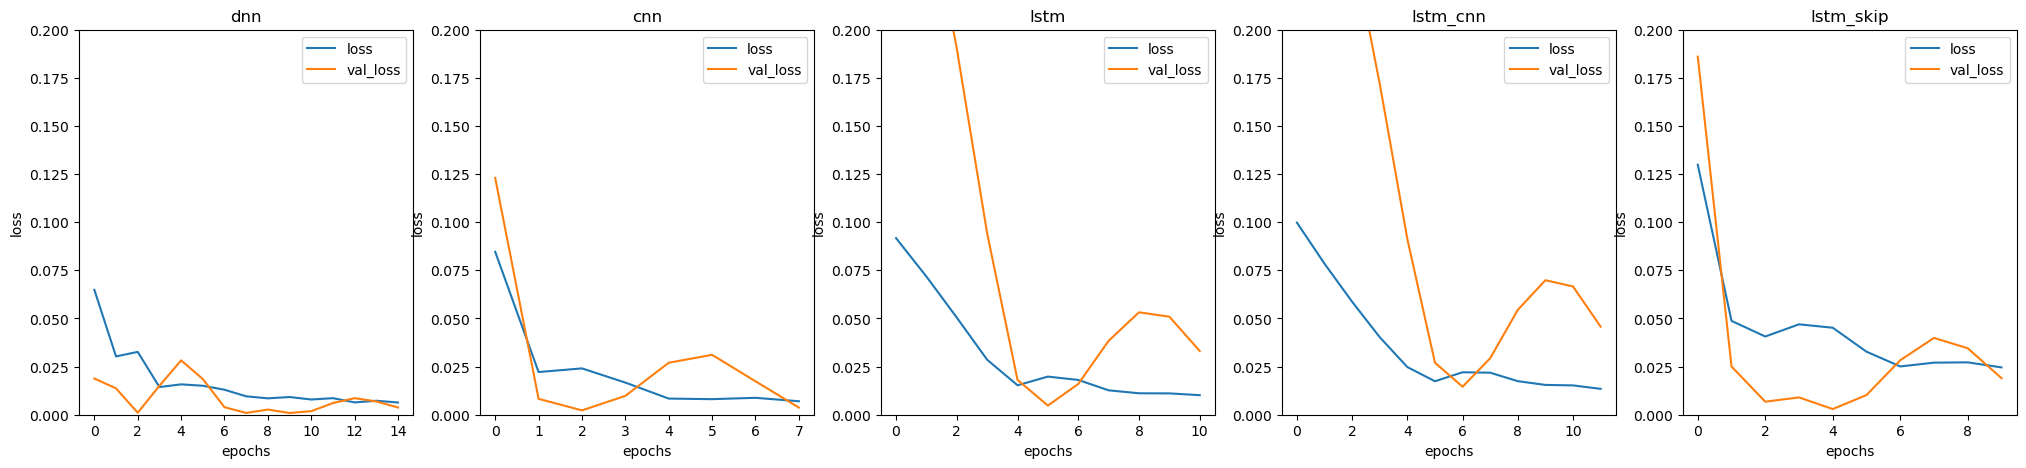

In [27]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


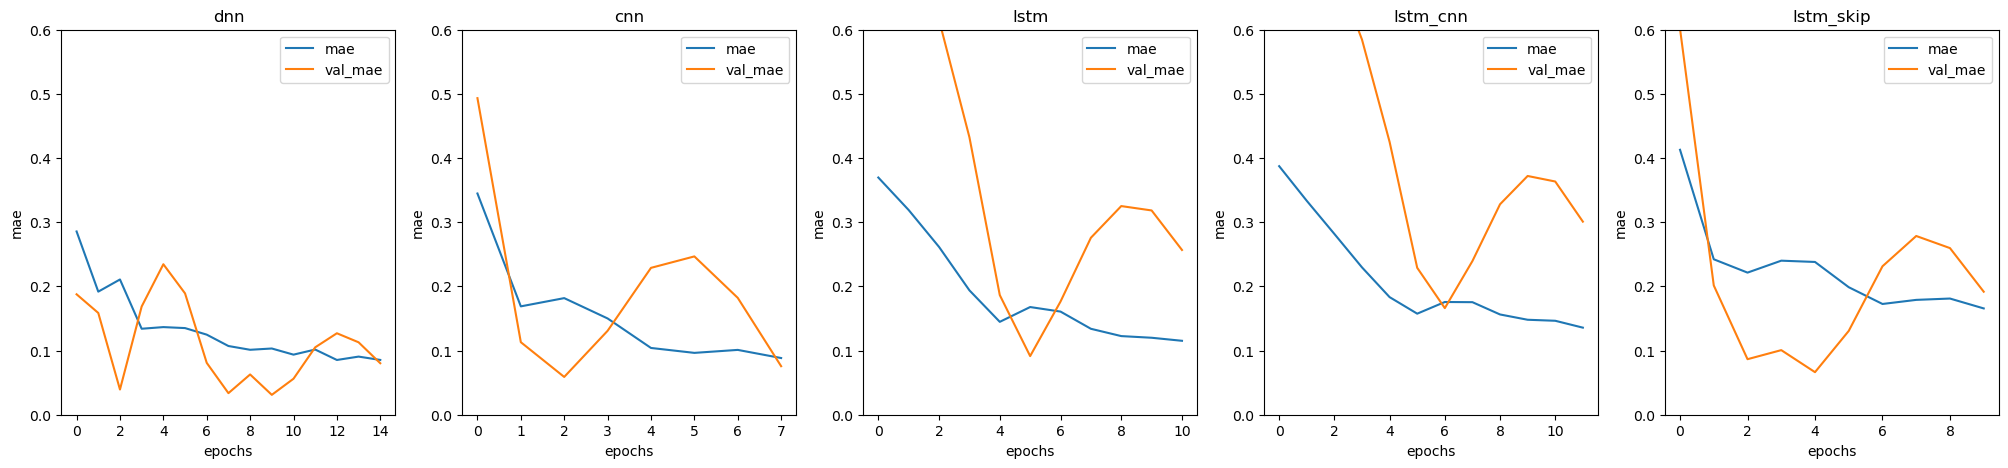

In [28]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

In [29]:
data_path = "/mnt/d/Learning/tensorflow_learning/datasets/POP.csv"
data = load_data(data_path, col=['value'])

In [30]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * data['value'].mean()
print(performance_df)

1/1 [==============================] - 0s 78ms/step - loss: 0.0030 - mae: 0.0663
                mae      error_mw
dnn        0.030971   7552.087938
cnn        0.058879  14357.409878
lstm       0.091358  22277.476722
lstm_cnn   0.166128  40509.893433
lstm_skip  0.066322  16172.376900


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 246ms/step
First Two Weeks of Predictions


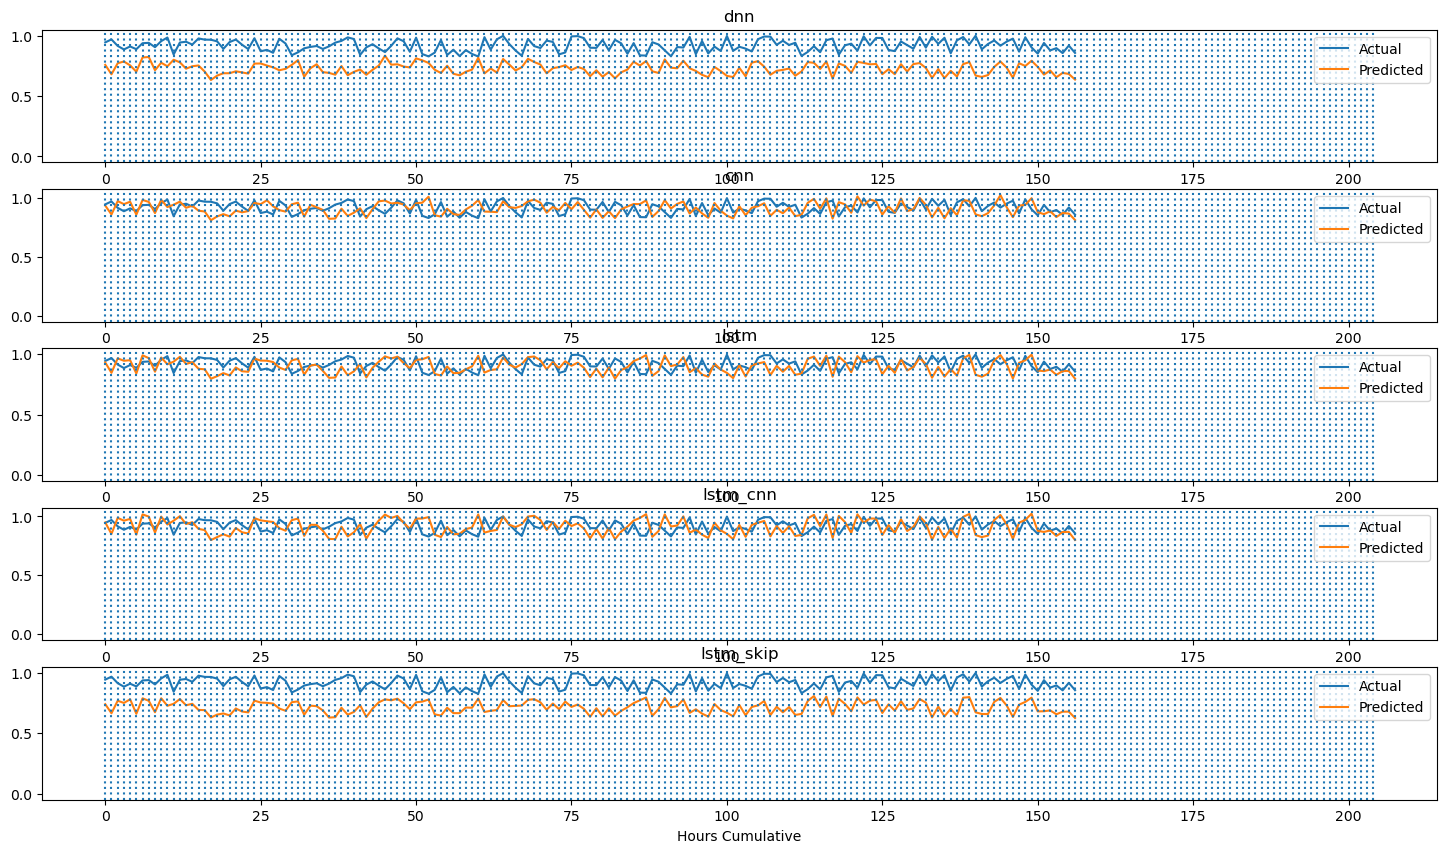

In [38]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 204

vline = np.linspace(0, days, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')

In [39]:
model_configs_new = dict()

def cfg_model_run(model, history, test_ds):
    return {"model": model, "history" : history, "test_ds": test_ds}

def get_callbacks(model_name):
  callbacks = []
  MC = tf.keras.callbacks.ModelCheckpoint(f'saved_models/ts_practice_6/{model_name}', monitor='val_loss', save_best_only='True', verbose=1)
  ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights='True')
  return [MC, ES]

def run_model(model_name, model_func, model_configs_new, epochs):
    
    n_steps, n_horizon, n_features, lr = get_params(multivar=False)
    train_ds, val_ds, test_ds = build_dataset(n_steps=n_steps, n_horizon=n_horizon, multi_var=False)

    model = model_func(n_steps, n_horizon, n_features, lr=lr)

    model_hist = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

    model_configs_new[model_name] = cfg_model_run(model, model_hist, test_ds)
    return test_ds

In [40]:
def dnn_model(n_steps, n_horizon, n_features, lr):
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(n_steps, n_features)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='dnn')
    
    loss=tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model


dnn = dnn_model(*get_params(multivar=False))
dnn.summary()

Model: "dnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 7)                 0         
                                                                 
 dense (Dense)               (None, 128)               1024      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17,665
Trainable params: 17,665
Non-trainable par

In [41]:
def cnn_model(n_steps, n_horizon, n_features, lr=3e-4):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="CNN")
    
    loss= tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

cnn = cnn_model(*get_params(multivar=False))
cnn.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout (Dropout)           (None, 64)                0       

In [42]:
def lstm_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(72, activation='relu', input_shape=(n_steps, n_features), return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name='lstm')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm = lstm_model(*get_params(multivar=False))
lstm.summary()

Model: "lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 72)             21312     
                                                                 
 lstm_1 (LSTM)               (None, 48)                23232     
                                                                 
 flatten (Flatten)           (None, 48)                0         
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense (Dense)               (None, 128)               6272      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129    

In [43]:
def lstm_cnn_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu', input_shape=(n_steps,n_features)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.LSTM(72, activation='relu', return_sequences=True),
        tf.keras.layers.LSTM(48, activation='relu', return_sequences=False),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(n_horizon)
    ], name="lstm_cnn")
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_cnn = lstm_cnn_model(*get_params(multivar=False))
lstm_cnn.summary()

Model: "lstm_cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 64)             192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             8256      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 1, 72)             39456     
                                                                 
 lstm_1 (LSTM)               (None, 48)                232

In [44]:
def lstm_cnn_skip_model(n_steps, n_horizon, n_features, lr):
    
    tf.keras.backend.clear_session()
    
   
    inputs = tf.keras.layers.Input(shape=(n_steps,n_features), name='main')
    
    conv1 = tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu')(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling1D(2)(conv1)
    conv2 = tf.keras.layers.Conv1D(64, kernel_size=2, activation='relu')(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling1D(2)(conv2)
    lstm_1 = tf.keras.layers.LSTM(72, activation='relu', return_sequences=True)(max_pool_2)
    lstm_2 = tf.keras.layers.LSTM(48, activation='relu', return_sequences=False)(lstm_1)
    flatten = tf.keras.layers.Flatten()(lstm_2)
    
    skip_flatten = tf.keras.layers.Flatten()(inputs)

    concat = tf.keras.layers.Concatenate(axis=-1)([flatten, skip_flatten])
    drop_1 = tf.keras.layers.Dropout(0.3)(concat)
    dense_1 = tf.keras.layers.Dense(128, activation='relu')(drop_1)
    drop_2 = tf.keras.layers.Dropout(0.3)(dense_1)
    output = tf.keras.layers.Dense(n_horizon)(drop_2)
    
    model = tf.keras.Model(inputs=inputs, outputs=output, name='lstm_skip')
    
    loss = tf.keras.losses.Huber()
    optimizer = tf.keras.optimizers.Adam(lr=lr)
    
    model.compile(loss=loss, optimizer='adam', metrics=['mae'])
    
    return model

lstm_skip = lstm_cnn_skip_model(*get_params(multivar=False))
lstm_skip.summary()

Model: "lstm_skip"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 main (InputLayer)              [(None, 7, 1)]       0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 6, 64)        192         ['main[0][0]']                   
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 3, 64)        0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 2, 64)        8256        ['max_pooling1d[0][0]']          
                                                                                          

In [45]:
model_configs_new=dict()
run_model("dnn", dnn_model, model_configs_new, epochs=150)
run_model("cnn", cnn_model, model_configs_new, epochs=150)
run_model("lstm", lstm_model, model_configs_new, epochs=150)
run_model("lstm_cnn", lstm_cnn_model, model_configs_new, epochs=150)
run_model("lstm_skip", lstm_cnn_skip_model, model_configs_new, epochs=150)

Prediction lookback (n_steps): 7
Prediction horizon (n_horizon): 1
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
3/3 [==============================] - 1s 89ms/step - loss: 255376.2500 - mae: 255376.7500 - val_loss: 274939.9062 - val_mae: 274940.4062
Epoch 2/150
3/3 [==============================] - 0s 36ms/step - loss: 172799.6719 - mae: 172800.1562 - val_loss: 153211.1094 - val_mae: 153211.6250
Epoch 3/150
3/3 [==============================] - 0s 41ms/step - loss: 87890.5469 - mae: 87891.0469 - val_loss: 28217.7969 - val_mae: 28218.2969
Epoch 4/150
3/3 [==============================] - 0s 31ms/step - loss: 42546.1641 - mae: 42546.6641 - val_loss: 71998.7734 - val_mae: 71999.2734
Epoch 5/150
3/3 [==============================] - 0s 31ms/step - loss: 63609.3281 - mae: 63609.8281 - val_loss: 88955.6484 - val_mae: 88956.1562
Epoch 6/150
3/3 [=======================

3/3 [==============================] - 0s 28ms/step - loss: 24020.9199 - mae: 24021.4180 - val_loss: 33101.2148 - val_mae: 33101.7148
Epoch 56/150
3/3 [==============================] - 0s 28ms/step - loss: 21700.2695 - mae: 21700.7695 - val_loss: 50850.6133 - val_mae: 50851.1133
Epoch 57/150
3/3 [==============================] - 0s 28ms/step - loss: 23679.5000 - mae: 23679.9980 - val_loss: 39850.4062 - val_mae: 39850.9062
Epoch 58/150
3/3 [==============================] - 0s 29ms/step - loss: 21730.2441 - mae: 21730.7461 - val_loss: 34995.7148 - val_mae: 34996.2148
Epoch 59/150
3/3 [==============================] - 0s 29ms/step - loss: 21029.1465 - mae: 21029.6465 - val_loss: 43843.0391 - val_mae: 43843.5430
Epoch 60/150
3/3 [==============================] - 0s 30ms/step - loss: 23531.0801 - mae: 23531.5801 - val_loss: 39359.6133 - val_mae: 39360.1133
Epoch 61/150
3/3 [==============================] - 0s 29ms/step - loss: 22904.1758 - mae: 22904.6758 - val_loss: 32397.2715 - val_

Epoch 111/150
3/3 [==============================] - 0s 28ms/step - loss: 21008.8613 - mae: 21009.3613 - val_loss: 47026.9258 - val_mae: 47027.4258
Epoch 112/150
3/3 [==============================] - 0s 29ms/step - loss: 21272.5332 - mae: 21273.0332 - val_loss: 44824.9922 - val_mae: 44825.4922
Epoch 113/150
3/3 [==============================] - 0s 28ms/step - loss: 21739.8594 - mae: 21740.3594 - val_loss: 43897.9648 - val_mae: 43898.4648
Epoch 114/150
3/3 [==============================] - 0s 29ms/step - loss: 21376.8301 - mae: 21377.3301 - val_loss: 38838.7773 - val_mae: 38839.2734
Epoch 115/150
3/3 [==============================] - 0s 29ms/step - loss: 20986.7402 - mae: 20987.2383 - val_loss: 41964.3008 - val_mae: 41964.8008
Epoch 116/150
3/3 [==============================] - 0s 31ms/step - loss: 20865.1582 - mae: 20865.6582 - val_loss: 48145.6875 - val_mae: 48146.1875
Epoch 117/150
3/3 [==============================] - 0s 30ms/step - loss: 21461.7695 - mae: 21462.2676 - val_los

Prediction lookback (n_steps): 7
Prediction horizon (n_horizon): 1
Batch Size: 256
Datasets:
(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))
Epoch 1/150
3/3 [==============================] - 1s 109ms/step - loss: 219163.3125 - mae: 219163.8125 - val_loss: 244108.3281 - val_mae: 244108.8438
Epoch 2/150
3/3 [==============================] - 0s 32ms/step - loss: 159933.3750 - mae: 159933.8594 - val_loss: 150511.8281 - val_mae: 150512.3281
Epoch 3/150
3/3 [==============================] - 0s 28ms/step - loss: 88434.3438 - mae: 88434.8438 - val_loss: 40206.5156 - val_mae: 40207.0156
Epoch 4/150
3/3 [==============================] - 0s 32ms/step - loss: 43019.8828 - mae: 43020.3828 - val_loss: 65772.7500 - val_mae: 65773.2500
Epoch 5/150
3/3 [==============================] - 0s 28ms/step - loss: 64512.7695 - mae: 64513.2695 - val_loss: 83707.2500 - val_mae: 83707.7422
Epoch 6/150
3/3 [======================

3/3 [==============================] - 0s 45ms/step - loss: 29172.8828 - mae: 29173.3828 - val_loss: 10660.5488 - val_mae: 10661.0488
Epoch 56/150
3/3 [==============================] - 0s 37ms/step - loss: 28389.6152 - mae: 28390.1152 - val_loss: 2142.6406 - val_mae: 2143.1406
Epoch 57/150
3/3 [==============================] - 0s 32ms/step - loss: 27732.6328 - mae: 27733.1309 - val_loss: 10562.7510 - val_mae: 10563.2510
Epoch 58/150
3/3 [==============================] - 0s 42ms/step - loss: 28249.9512 - mae: 28250.4492 - val_loss: 9466.7129 - val_mae: 9467.2129
Epoch 59/150
3/3 [==============================] - 0s 41ms/step - loss: 29054.4863 - mae: 29054.9863 - val_loss: 4941.3701 - val_mae: 4941.8701
Epoch 60/150
3/3 [==============================] - 0s 50ms/step - loss: 29892.1387 - mae: 29892.6426 - val_loss: 4289.5337 - val_mae: 4290.0337
Epoch 61/150
3/3 [==============================] - 0s 33ms/step - loss: 29204.7441 - mae: 29205.2441 - val_loss: 11008.8428 - val_mae: 110

3/3 [==============================] - 0s 36ms/step - loss: 27743.0723 - mae: 27743.5723 - val_loss: 1472.5173 - val_mae: 1473.0173
Epoch 112/150
3/3 [==============================] - 0s 35ms/step - loss: 27820.4590 - mae: 27820.9590 - val_loss: 3737.5391 - val_mae: 3738.0391
Epoch 113/150
3/3 [==============================] - 0s 35ms/step - loss: 27777.1016 - mae: 27777.6035 - val_loss: 15814.9199 - val_mae: 15815.4199
Epoch 114/150
3/3 [==============================] - 0s 35ms/step - loss: 27120.7773 - mae: 27121.2773 - val_loss: 4152.8857 - val_mae: 4153.3857
Epoch 115/150
3/3 [==============================] - 0s 35ms/step - loss: 27818.5918 - mae: 27819.0918 - val_loss: 1365.3516 - val_mae: 1365.8516
Epoch 116/150
3/3 [==============================] - 0s 43ms/step - loss: 28836.5645 - mae: 28837.0664 - val_loss: 23511.3574 - val_mae: 23511.8574
Epoch 117/150
3/3 [==============================] - 0s 33ms/step - loss: 27447.9043 - mae: 27448.4023 - val_loss: 3071.2944 - val_mae

Epoch 1/150
3/3 [==============================] - 3s 207ms/step - loss: 211831.2656 - mae: 211831.7656 - val_loss: 289440.5000 - val_mae: 289441.0000
Epoch 2/150
3/3 [==============================] - 0s 82ms/step - loss: 205927.7188 - mae: 205928.2188 - val_loss: 297096.1562 - val_mae: 297096.6562
Epoch 3/150
3/3 [==============================] - 0s 93ms/step - loss: 211400.8281 - mae: 211401.3281 - val_loss: 292963.2812 - val_mae: 292963.7812
Epoch 4/150
3/3 [==============================] - 0s 74ms/step - loss: 208875.8594 - mae: 208876.3594 - val_loss: 287991.2812 - val_mae: 287991.7812
Epoch 5/150
3/3 [==============================] - 0s 77ms/step - loss: 207370.1719 - mae: 207370.6719 - val_loss: 287775.0938 - val_mae: 287775.5938
Epoch 6/150
3/3 [==============================] - 0s 74ms/step - loss: 205476.4844 - mae: 205476.9844 - val_loss: 282524.9375 - val_mae: 282525.4375
Epoch 7/150
3/3 [==============================] - 0s 72ms/step - loss: 201562.2969 - mae: 201562.7

3/3 [==============================] - 0s 81ms/step - loss: 37528.5469 - mae: 37529.0469 - val_loss: 54875.4023 - val_mae: 54875.9062
Epoch 57/150
3/3 [==============================] - 0s 81ms/step - loss: 37474.6914 - mae: 37475.1953 - val_loss: 55439.2734 - val_mae: 55439.7695
Epoch 58/150
3/3 [==============================] - 0s 81ms/step - loss: 35264.0898 - mae: 35264.5898 - val_loss: 50857.3398 - val_mae: 50857.8398
Epoch 59/150
3/3 [==============================] - 0s 78ms/step - loss: 35411.8047 - mae: 35412.3047 - val_loss: 47374.5547 - val_mae: 47375.0586
Epoch 60/150
3/3 [==============================] - 0s 83ms/step - loss: 34751.4883 - mae: 34751.9883 - val_loss: 47358.7773 - val_mae: 47359.2773
Epoch 61/150
3/3 [==============================] - 0s 75ms/step - loss: 34169.6992 - mae: 34170.1992 - val_loss: 52334.0508 - val_mae: 52334.5469
Epoch 62/150
3/3 [==============================] - 0s 80ms/step - loss: 36944.6562 - mae: 36945.1562 - val_loss: 55143.8711 - val_

Epoch 112/150
3/3 [==============================] - 0s 82ms/step - loss: 22568.2363 - mae: 22568.7363 - val_loss: 96520.0703 - val_mae: 96520.5703
Epoch 113/150
3/3 [==============================] - 0s 86ms/step - loss: 22921.2637 - mae: 22921.7637 - val_loss: 96535.9453 - val_mae: 96536.4453
Epoch 114/150
3/3 [==============================] - 0s 74ms/step - loss: 23050.1406 - mae: 23050.6426 - val_loss: 97406.7031 - val_mae: 97407.2031
Epoch 115/150
3/3 [==============================] - 0s 93ms/step - loss: 23879.9395 - mae: 23880.4395 - val_loss: 94469.5391 - val_mae: 94470.0469
Epoch 116/150
3/3 [==============================] - 0s 84ms/step - loss: 22321.1758 - mae: 22321.6777 - val_loss: 95031.5234 - val_mae: 95032.0234
Epoch 117/150
3/3 [==============================] - 0s 72ms/step - loss: 23138.8789 - mae: 23139.3789 - val_loss: 96668.3438 - val_mae: 96668.8438
Epoch 118/150
3/3 [==============================] - 0s 81ms/step - loss: 23027.4766 - mae: 23027.9746 - val_los

Epoch 1/150
3/3 [==============================] - 3s 181ms/step - loss: 226756.8594 - mae: 226757.3594 - val_loss: 316445.1875 - val_mae: 316445.6875
Epoch 2/150
3/3 [==============================] - 0s 43ms/step - loss: 226720.0781 - mae: 226720.5781 - val_loss: 315984.0000 - val_mae: 315984.4688
Epoch 3/150
3/3 [==============================] - 0s 44ms/step - loss: 226401.7812 - mae: 226402.2812 - val_loss: 315404.7812 - val_mae: 315405.2812
Epoch 4/150
3/3 [==============================] - 0s 45ms/step - loss: 226129.1406 - mae: 226129.6406 - val_loss: 316406.5938 - val_mae: 316407.0938
Epoch 5/150
3/3 [==============================] - 0s 63ms/step - loss: 226737.3125 - mae: 226737.8125 - val_loss: 316184.7500 - val_mae: 316185.2188
Epoch 6/150
3/3 [==============================] - 0s 49ms/step - loss: 226840.9375 - mae: 226841.4219 - val_loss: 317405.5938 - val_mae: 317406.0938
Epoch 7/150
3/3 [==============================] - 0s 47ms/step - loss: 227280.7500 - mae: 227281.2

3/3 [==============================] - 0s 45ms/step - loss: 66077.1953 - mae: 66077.6953 - val_loss: 37561.5742 - val_mae: 37562.0781
Epoch 57/150
3/3 [==============================] - 0s 42ms/step - loss: 70341.0312 - mae: 70341.5312 - val_loss: 51954.3867 - val_mae: 51954.8906
Epoch 58/150
3/3 [==============================] - 0s 41ms/step - loss: 70632.2812 - mae: 70632.7812 - val_loss: 49354.9531 - val_mae: 49355.4531
Epoch 59/150
3/3 [==============================] - 0s 43ms/step - loss: 70203.3203 - mae: 70203.8203 - val_loss: 47410.8281 - val_mae: 47411.3242
Epoch 60/150
3/3 [==============================] - 0s 43ms/step - loss: 68305.7109 - mae: 68306.2109 - val_loss: 44453.5352 - val_mae: 44454.0312
Epoch 61/150
3/3 [==============================] - 0s 43ms/step - loss: 67099.5625 - mae: 67100.0625 - val_loss: 42092.5273 - val_mae: 42093.0273
Epoch 62/150
3/3 [==============================] - 0s 44ms/step - loss: 65243.4531 - mae: 65243.9570 - val_loss: 44128.3398 - val_

Epoch 112/150
3/3 [==============================] - 0s 49ms/step - loss: 66649.0703 - mae: 66649.5625 - val_loss: 30234.9082 - val_mae: 30235.4082
Epoch 113/150
3/3 [==============================] - 0s 59ms/step - loss: 65402.2148 - mae: 65402.7148 - val_loss: 31863.1660 - val_mae: 31863.6660
Epoch 114/150
3/3 [==============================] - 0s 44ms/step - loss: 68399.5859 - mae: 68400.0859 - val_loss: 33540.3867 - val_mae: 33540.8867
Epoch 115/150
3/3 [==============================] - 0s 39ms/step - loss: 65818.6172 - mae: 65819.1172 - val_loss: 28813.1270 - val_mae: 28813.6270
Epoch 116/150
3/3 [==============================] - 0s 46ms/step - loss: 68967.0312 - mae: 68967.5312 - val_loss: 27698.3984 - val_mae: 27698.8984
Epoch 117/150
3/3 [==============================] - 0s 45ms/step - loss: 67145.1016 - mae: 67145.6016 - val_loss: 26271.5918 - val_mae: 26272.0918
Epoch 118/150
3/3 [==============================] - 0s 39ms/step - loss: 67736.3125 - mae: 67736.8125 - val_los

Epoch 1/150
3/3 [==============================] - 3s 181ms/step - loss: 252460.2344 - mae: 252460.7188 - val_loss: 307032.4688 - val_mae: 307032.9375
Epoch 2/150
3/3 [==============================] - 0s 47ms/step - loss: 209549.8594 - mae: 209550.3594 - val_loss: 239846.8750 - val_mae: 239847.3906
Epoch 3/150
3/3 [==============================] - 0s 45ms/step - loss: 160319.6562 - mae: 160320.1562 - val_loss: 181674.9375 - val_mae: 181675.4219
Epoch 4/150
3/3 [==============================] - 0s 45ms/step - loss: 120773.4922 - mae: 120773.9922 - val_loss: 115891.9453 - val_mae: 115892.4453
Epoch 5/150
3/3 [==============================] - 0s 55ms/step - loss: 82464.2656 - mae: 82464.7656 - val_loss: 44480.4648 - val_mae: 44480.9688
Epoch 6/150
3/3 [==============================] - 0s 50ms/step - loss: 65369.3086 - mae: 65369.8047 - val_loss: 8503.5205 - val_mae: 8504.0205
Epoch 7/150
3/3 [==============================] - 0s 43ms/step - loss: 66826.2266 - mae: 66826.7266 - val_lo

Epoch 57/150
3/3 [==============================] - 0s 47ms/step - loss: 32159.4844 - mae: 32159.9844 - val_loss: 92623.2188 - val_mae: 92623.7188
Epoch 58/150
3/3 [==============================] - 0s 48ms/step - loss: 31373.6875 - mae: 31374.1895 - val_loss: 96496.1016 - val_mae: 96496.6016
Epoch 59/150
3/3 [==============================] - 0s 45ms/step - loss: 30470.8750 - mae: 30471.3730 - val_loss: 90261.2734 - val_mae: 90261.7734
Epoch 60/150
3/3 [==============================] - 0s 43ms/step - loss: 32382.1758 - mae: 32382.6758 - val_loss: 86462.0625 - val_mae: 86462.5625
Epoch 61/150
3/3 [==============================] - 0s 43ms/step - loss: 29418.4434 - mae: 29418.9434 - val_loss: 88808.3281 - val_mae: 88808.8281
Epoch 62/150
3/3 [==============================] - 0s 53ms/step - loss: 31470.0039 - mae: 31470.5059 - val_loss: 93187.4688 - val_mae: 93187.9688
Epoch 63/150
3/3 [==============================] - 0s 51ms/step - loss: 30175.0879 - mae: 30175.5879 - val_loss: 9311

3/3 [==============================] - 0s 52ms/step - loss: 22863.5156 - mae: 22864.0156 - val_loss: 98182.9062 - val_mae: 98183.4062
Epoch 113/150
3/3 [==============================] - 0s 46ms/step - loss: 23532.6699 - mae: 23533.1699 - val_loss: 95294.7656 - val_mae: 95295.2578
Epoch 114/150
3/3 [==============================] - 0s 56ms/step - loss: 23636.8867 - mae: 23637.3867 - val_loss: 99535.2578 - val_mae: 99535.7656
Epoch 115/150
3/3 [==============================] - 0s 49ms/step - loss: 24172.5332 - mae: 24173.0332 - val_loss: 106226.5625 - val_mae: 106227.0625
Epoch 116/150
3/3 [==============================] - 0s 45ms/step - loss: 23243.1445 - mae: 23243.6426 - val_loss: 110043.5391 - val_mae: 110044.0391
Epoch 117/150
3/3 [==============================] - 0s 46ms/step - loss: 23620.4082 - mae: 23620.9062 - val_loss: 108295.3750 - val_mae: 108295.8750
Epoch 118/150
3/3 [==============================] - 0s 45ms/step - loss: 22432.6055 - mae: 22433.1055 - val_loss: 10101

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None))>

Loss Curves


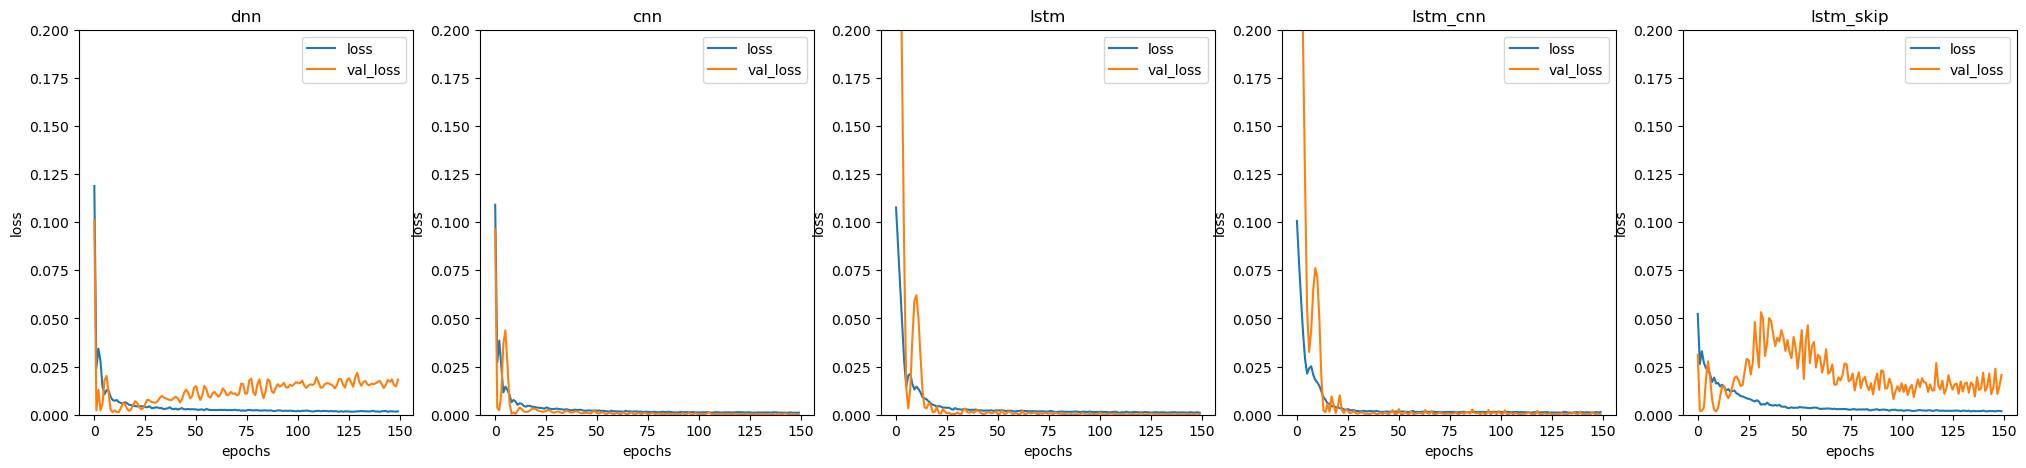

In [46]:
legend = list()

fig, axs = plt.subplots(1, 5, figsize=(25,5))

def plot_graphs(metric, val, ax, upper):
    ax.plot(val['history'].history[metric])
    ax.plot(val['history'].history[f'val_{metric}'])
    ax.set_title(key)
    ax.legend([metric, f"val_{metric}"])
    ax.set_xlabel('epochs')
    ax.set_ylabel(metric)
    ax.set_ylim([0, upper])
    
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('loss', val, ax, 0.2)
print("Loss Curves")

MAE Curves


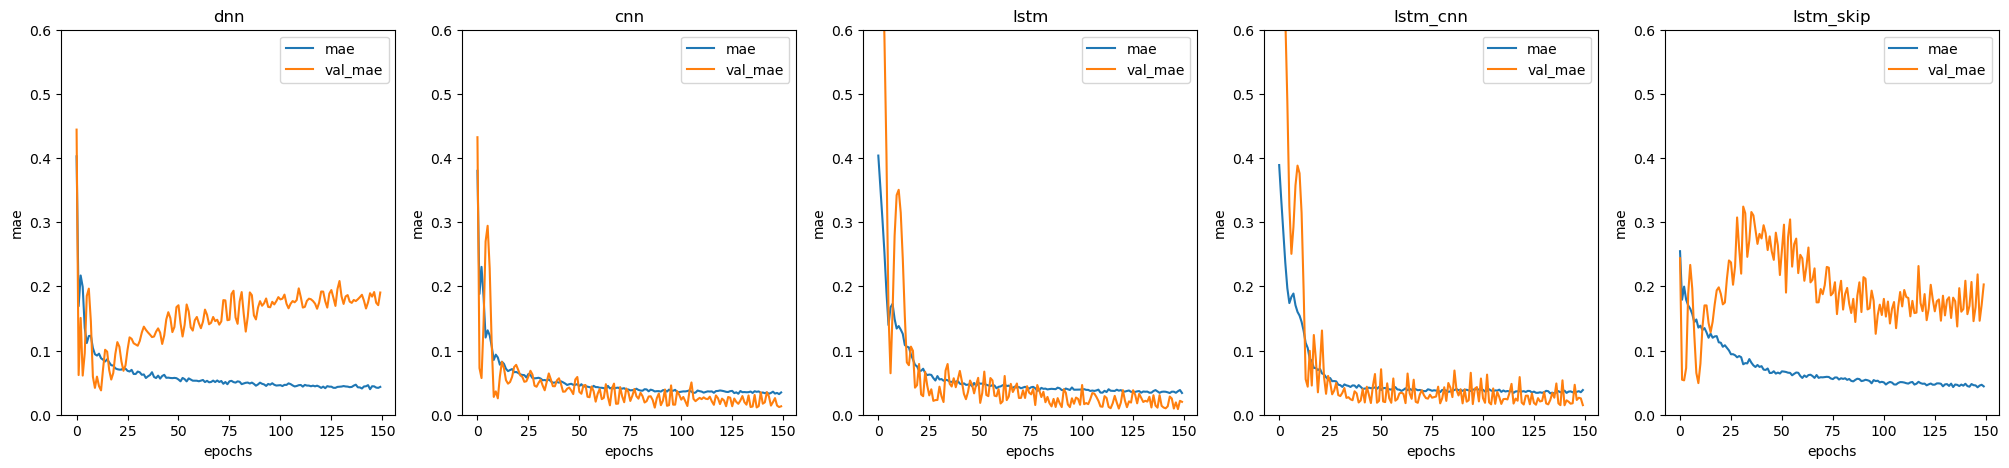

In [47]:
print("MAE Curves")
fig, axs = plt.subplots(1, 5, figsize=(25,5))
for (key, val), ax in zip(model_configs.items(), axs.flatten()):
    plot_graphs('mae', val, ax, 0.6)

In [48]:
data_path = "/mnt/d/Learning/tensorflow_learning/datasets/POP.csv"
data = load_data(data_path, col=['value'])

In [49]:
names = list()
performance = list()

for key, value in model_configs.items():
    names.append(key)
    mae = value['model'].evaluate(value['test_ds'])
    performance.append(mae[1])
    
performance_df = pd.DataFrame(performance, index=names, columns=['mae'])
performance_df['error_mw'] = performance_df['mae'] * data['value'].mean()
print(performance_df)

1/1 [==============================] - 0s 142ms/step - loss: 0.0206 - mae: 0.2030
                mae      error_mw
dnn        0.190456  46442.329326
cnn        0.013115   3198.161351
lstm       0.020083   4897.219918
lstm_cnn   0.014950   3645.618315
lstm_skip  0.203009  49503.322850


1/1 [==============================] - 0s 120ms/step
First Two Weeks of Predictions


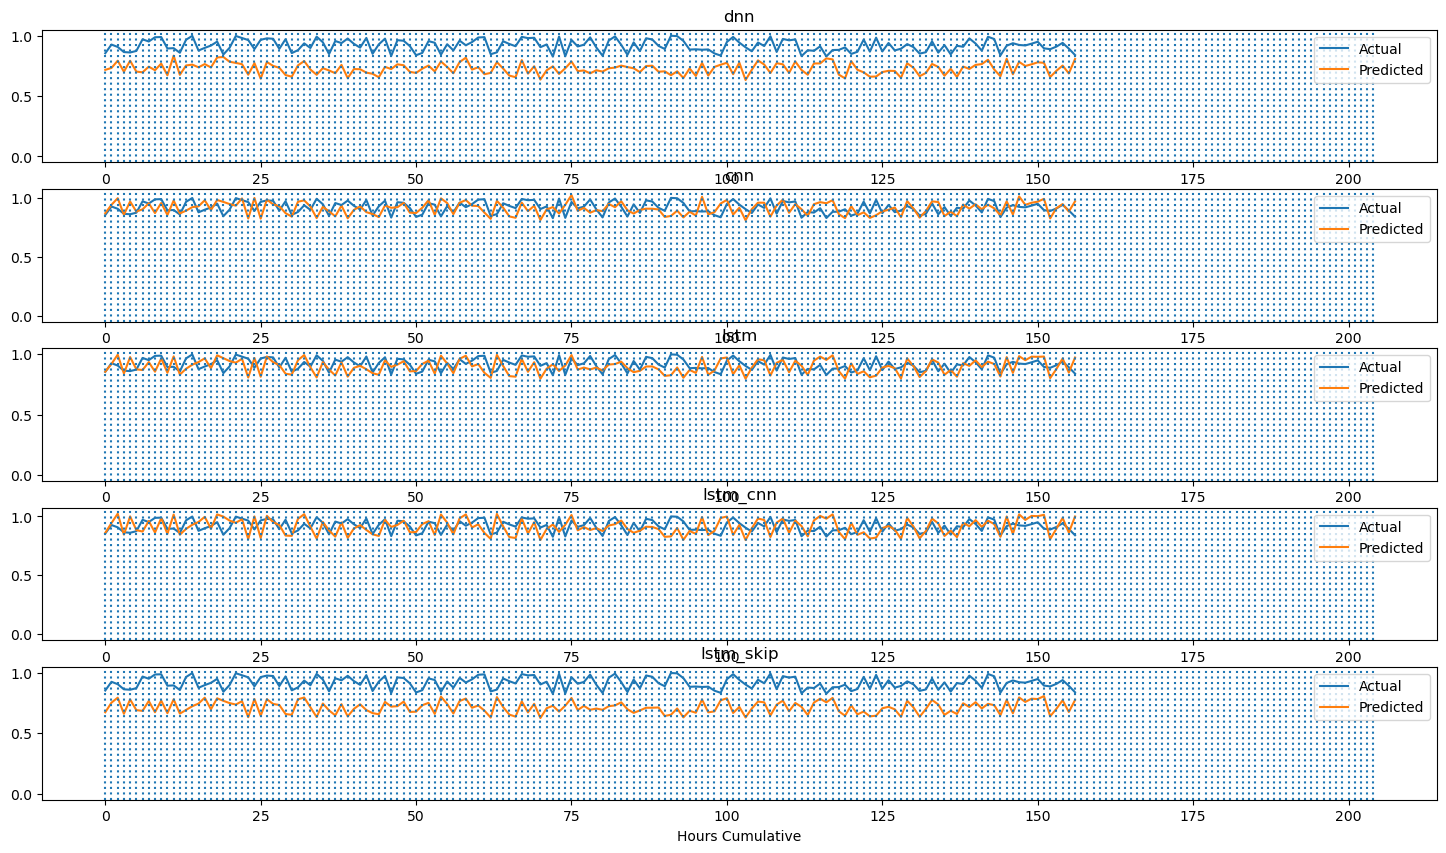

In [50]:
fig, axs = plt.subplots(5, 1, figsize=(18, 10))
days = 204

vline = np.linspace(0, days, days+1)

for (key, val), ax in zip(model_configs.items(), axs):

    test = val['test_ds']
    preds = val['model'].predict(test)

    xbatch, ybatch = iter(test).get_next()

    ax.plot(ybatch.numpy()[:days].reshape(-1))
    ax.plot(preds[:days].reshape(-1))
    ax.set_title(key)
    ax.vlines(vline, ymin=0, ymax=1, linestyle='dotted', transform = ax.get_xaxis_transform())
    ax.legend(["Actual", "Predicted"])

plt.xlabel("Hours Cumulative")
print('First Two Weeks of Predictions')